### A different set of functions to parse channel location information from an external file.
#### These scripts will load and parse the CSV file in ./pydas_readers/mapping/Channel_mapping_information_catalogue_v4.csv

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta

#-- To import a function on a relative path:
import sys
sys.path.append("./")
from pydas_readers.readers import load_das_h5
from pydas_readers.mapping import channel_mapping




In [2]:
#-- The file that contains our mapped channels is directly in the pydas_readers directory
channel_mapping.print_filename()

#-- In general, hardcoding a path into a function is bad practice, so we can make it adaptable like this:
#--  If a user wants to import a different version of the CSV, or store it somewhere else, we can update 
#--  the global variable as below

# channel_mapping.update_filename("some_different_place.csv")
# channel_mapping.print_filename()

./pydas_readers/mapping/Channel_mapping_information_catalouge_v4.csv


In [3]:
#-- We will get a dict() of information: channel, lat, lon, etc.
#-- data_type can be:
#--   "raw", with all channels and no mapping because not all channels can be mapped
#--   "mapped", indices of all those channels which can be assigned to lat/lon/dist
#--   "clean", where Ali carefully went through and excluded noisy channels, or those 
#--             where the mapping was less clear.
mapping = channel_mapping.get_mapping(data_type="clean",chan_spacing=2)
print(mapping.keys())
print(mapping['ii'])



dict_keys(['dd', 'ii', 'dx', 'lat', 'lon', 'flags'])
[ 398  399  400 ... 4392 4393 4394]


In [4]:

#-- Load data with the specified channels
input_dir = "./example_data_Istanbul/"
t_start = datetime.strptime('2023/02/02 10:20:10.0', '%Y/%m/%d %H:%M:%S.%f') 
t_end   = datetime.strptime('2023/02/02 10:20:25.0', '%Y/%m/%d %H:%M:%S.%f') 

#-- Specifically, argument ichan=[] to specify which channels should be loaded.
data, headers, axis = load_das_h5.load_das_custom(t_start, t_end, input_dir = input_dir, ichan = mapping['ii'], verbose=False, convert=True)

print("Data [npts x nchan]: {0}".format(np.shape(data)))
print("Requested channels: {0}".format(len(mapping['ii'])))



Data [npts x nchan]: (15001, 3316)
Requested channels: 3316


In [5]:
#-- How do the "headers", "axis", and "mapping" dictionaries agree?
print("Number of Channels (headers, axis, mapping)")
print(headers['nchan'])
print(len(axis['dd']))
print(len(mapping['dd']))
print("")

print("dx (headers, axis, mapping)")
print(headers['dx'])
print(axis['dd'][1]- axis['dd'][0])
print(mapping['dx'][20])
print("")


print("d0 (headers, axis, mapping)")
print(headers['d0'])
print(axis['dd'][0])
print(mapping['dd'][0])
print("")

print("d1 (headers, axis, mapping)")
print(headers['d1'])
print(axis['dd'][-1])
print(mapping['dd'][-1])
print("")




Number of Channels (headers, axis, mapping)
3316
3316
3316

dx (headers, axis, mapping)
2
2.0419039726257324
1.93096918

d0 (headers, axis, mapping)
551.359787940979
551.359787940979
549.3179

d1 (headers, axis, mapping)
8710.808062553406
8710.808062553406
9006.25434



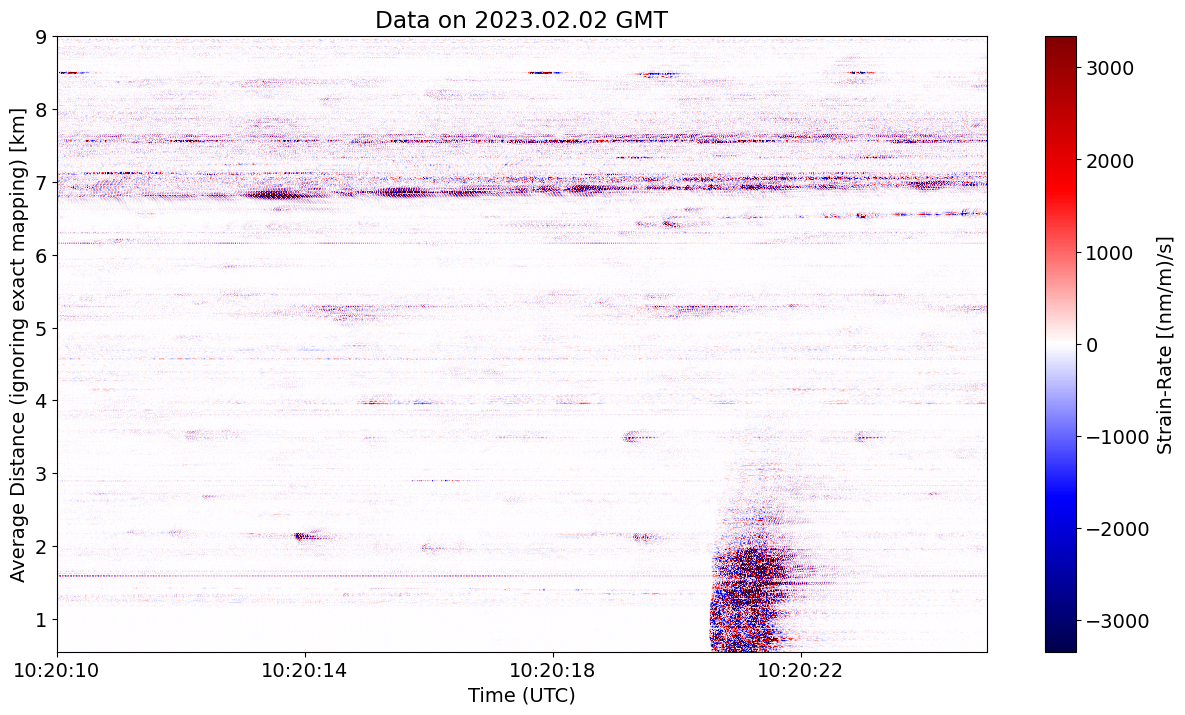

In [7]:
plt.rcParams.update({'font.size': 14})

#-- Define a function for making the waterfall plot:
def waterfall(data,headers,mapping,ax,vlim=0):

    #-- imshow data
    if(vlim==0):
        vlim = np.mean(np.abs(data))*10
    im = ax.imshow(data.T, aspect="auto", cmap='seismic', interpolation='antialiased', 
            extent=(0,headers["npts"]/headers["fs"], mapping["dd"][-1]/1000,mapping["dd"][0]/1000),
            vmin=-vlim, vmax=vlim)
    
    #-- y-axis
    ax.set_ylabel("Average Distance (ignoring exact mapping) [km]")

    #-- Define the x-tick marks we want, format the labels
    x_timestamp_interval = 4 # seconds
    x_positions = np.arange(0, headers["npts"]/headers["fs"], x_timestamp_interval)  # time-samples
    x_labels_times = [None]*len(x_positions)
    for i,t in enumerate(x_positions):
        x_labels_times[i] = (headers['t0'] + timedelta(seconds=t)).strftime('%H:%M:%S')
    ax.set_xticks(x_positions, x_labels_times)
    ax.set_xlabel("Time (UTC)")

    if(headers['unit']=="(nm/m)/s"):
        #-- Because we used the flag, "convert=True" when reading, the units are physical.
        plt.colorbar(im,label="Strain-Rate [(nm/m)/s]",ax=ax)
    else:
        plt.colorbar(im,label="Optical Intensity",ax=ax)
 

    ax.set_title('Data on {0} GMT'.format(headers['t0'].strftime('%Y.%m.%d')))
    ax.invert_yaxis()
    return ax

fig,ax = plt.subplots(figsize=(15,8))
ax = waterfall(data,headers,mapping,ax)

Data [npts x nchan]: (15001, 647)
Requested channels: 647


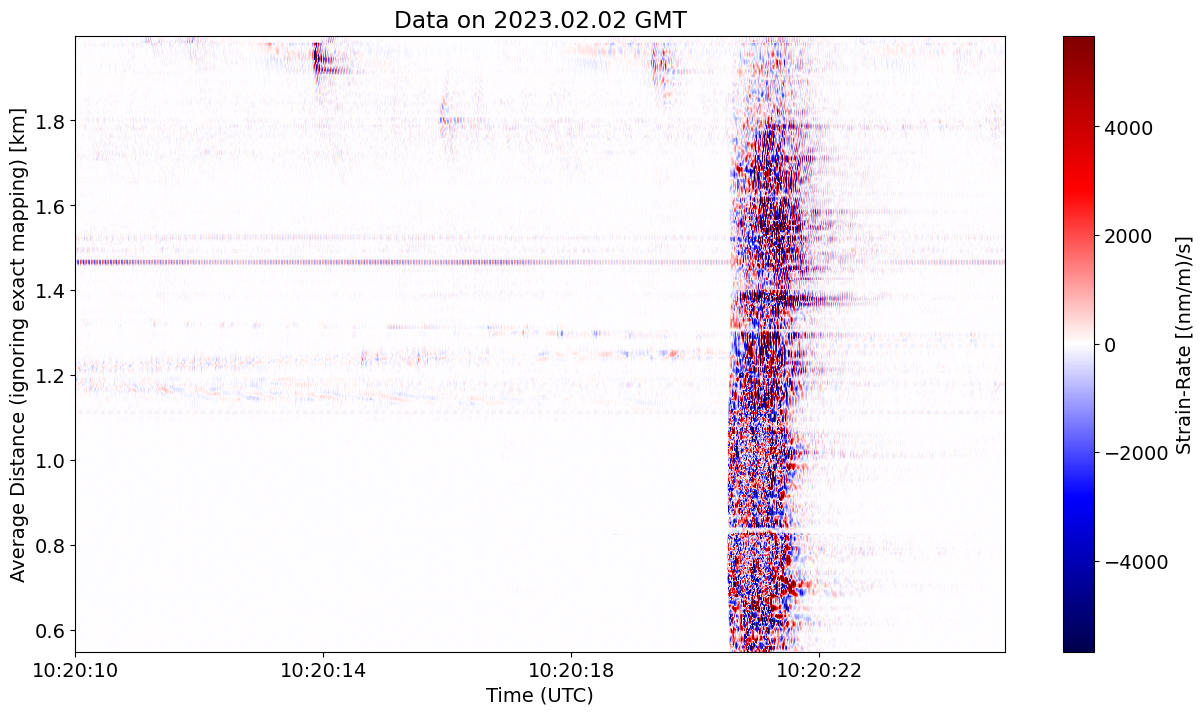

In [8]:
#-- Test: requesting d_start and d_end
#-- Note we'll request 0-2km, but the "clean" data doesn't have anything assigned before ~0.6km so that's where it really starts
mapping = channel_mapping.get_mapping(data_type="clean",chan_spacing=2,d_start=0,d_end=2000)

t_start = datetime.strptime('2023/02/02 10:20:10.0', '%Y/%m/%d %H:%M:%S.%f') 
t_end   = datetime.strptime('2023/02/02 10:20:25.0', '%Y/%m/%d %H:%M:%S.%f') 

#-- Load data with the specified channels. 
#-- Specifically, argument ichan=[] to specify which channels should be loaded.
data, headers, axis = load_das_h5.load_das_custom(t_start, t_end, input_dir = input_dir, ichan = mapping['ii'], verbose=False, convert=True)
print("Data [npts x nchan]: {0}".format(np.shape(data)))
print("Requested channels: {0}".format(len(mapping['ii'])))

fig,ax = plt.subplots(figsize=(15,8))
ax = waterfall(data,headers,mapping,ax)

Data [npts x nchan]: (15001, 65)
Requested channels: 65


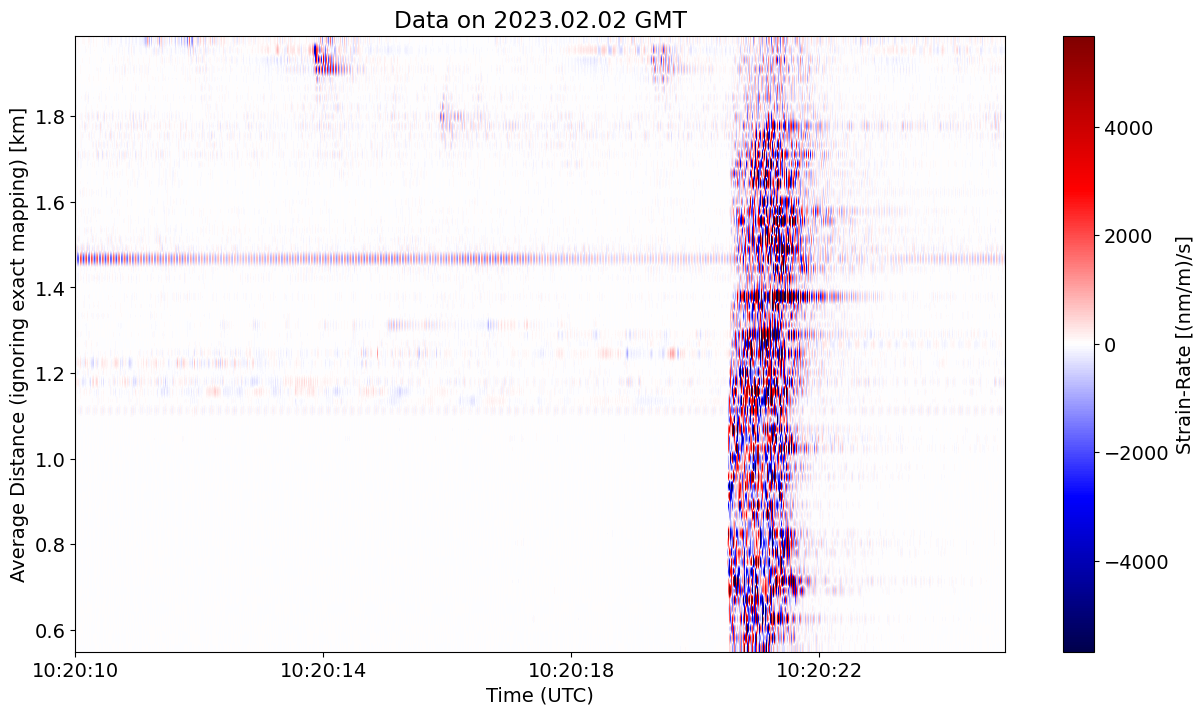

In [9]:
#-- Test: requesting "nth_channel" (spatial downsampling)
mapping = channel_mapping.get_mapping(data_type="clean",chan_spacing=2,d_start=0,d_end=2000, nth_channel=10)

t_start = datetime.strptime('2023/02/02 10:20:10.0', '%Y/%m/%d %H:%M:%S.%f') 
t_end   = datetime.strptime('2023/02/02 10:20:25.0', '%Y/%m/%d %H:%M:%S.%f') 

#-- Load data with the specified channels. 
#-- Specifically, argument ichan=[] to specify which channels should be loaded.
data, headers, axis = load_das_h5.load_das_custom(t_start, t_end, input_dir = input_dir, ichan = mapping['ii'], verbose=False, convert=True)
print("Data [npts x nchan]: {0}".format(np.shape(data)))
print("Requested channels: {0}".format(len(mapping['ii'])))

fig,ax = plt.subplots(figsize=(15,8))
ax = waterfall(data,headers,mapping,ax)


(5001, 39)
(1001, 10)
[1670 1671 1672 1673 1674 1675 1676 1677 1678 1679]
[417 418 419 420 421 422 423 424 425 426]
(5001, 197)
(1001, 50)
[398 399 400 401 402 403 404 405 406 407]
[ 99 100 101 102 103 104 105 106 107 108]


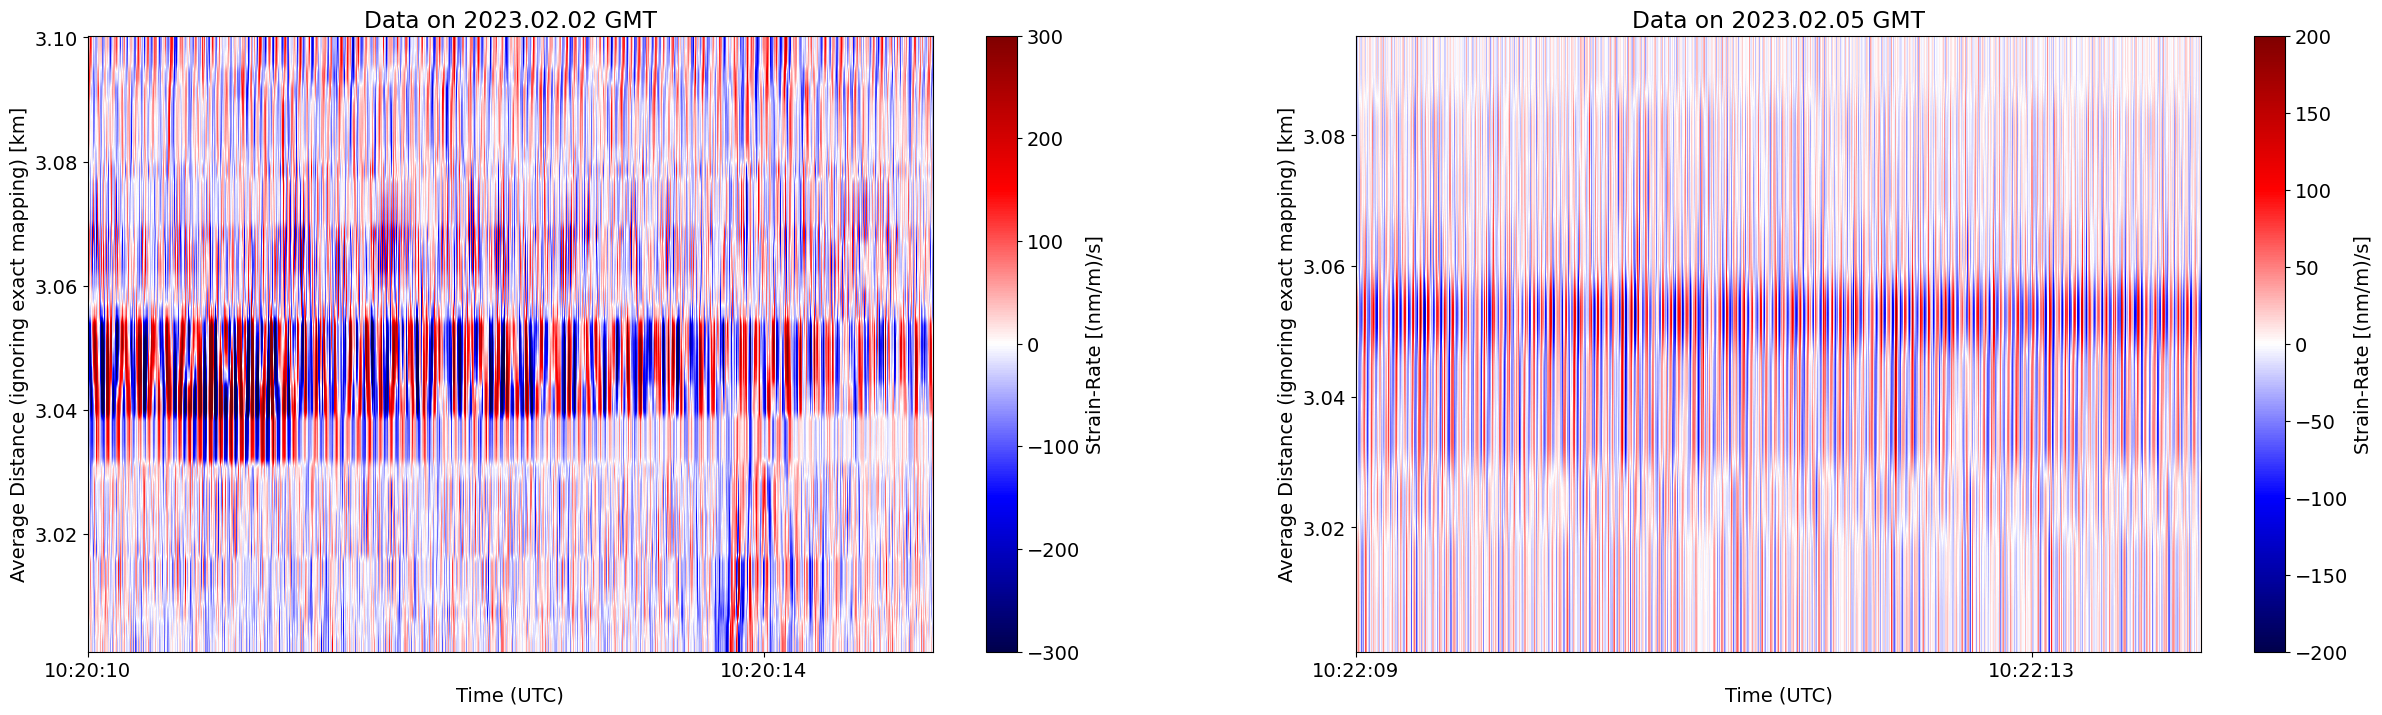

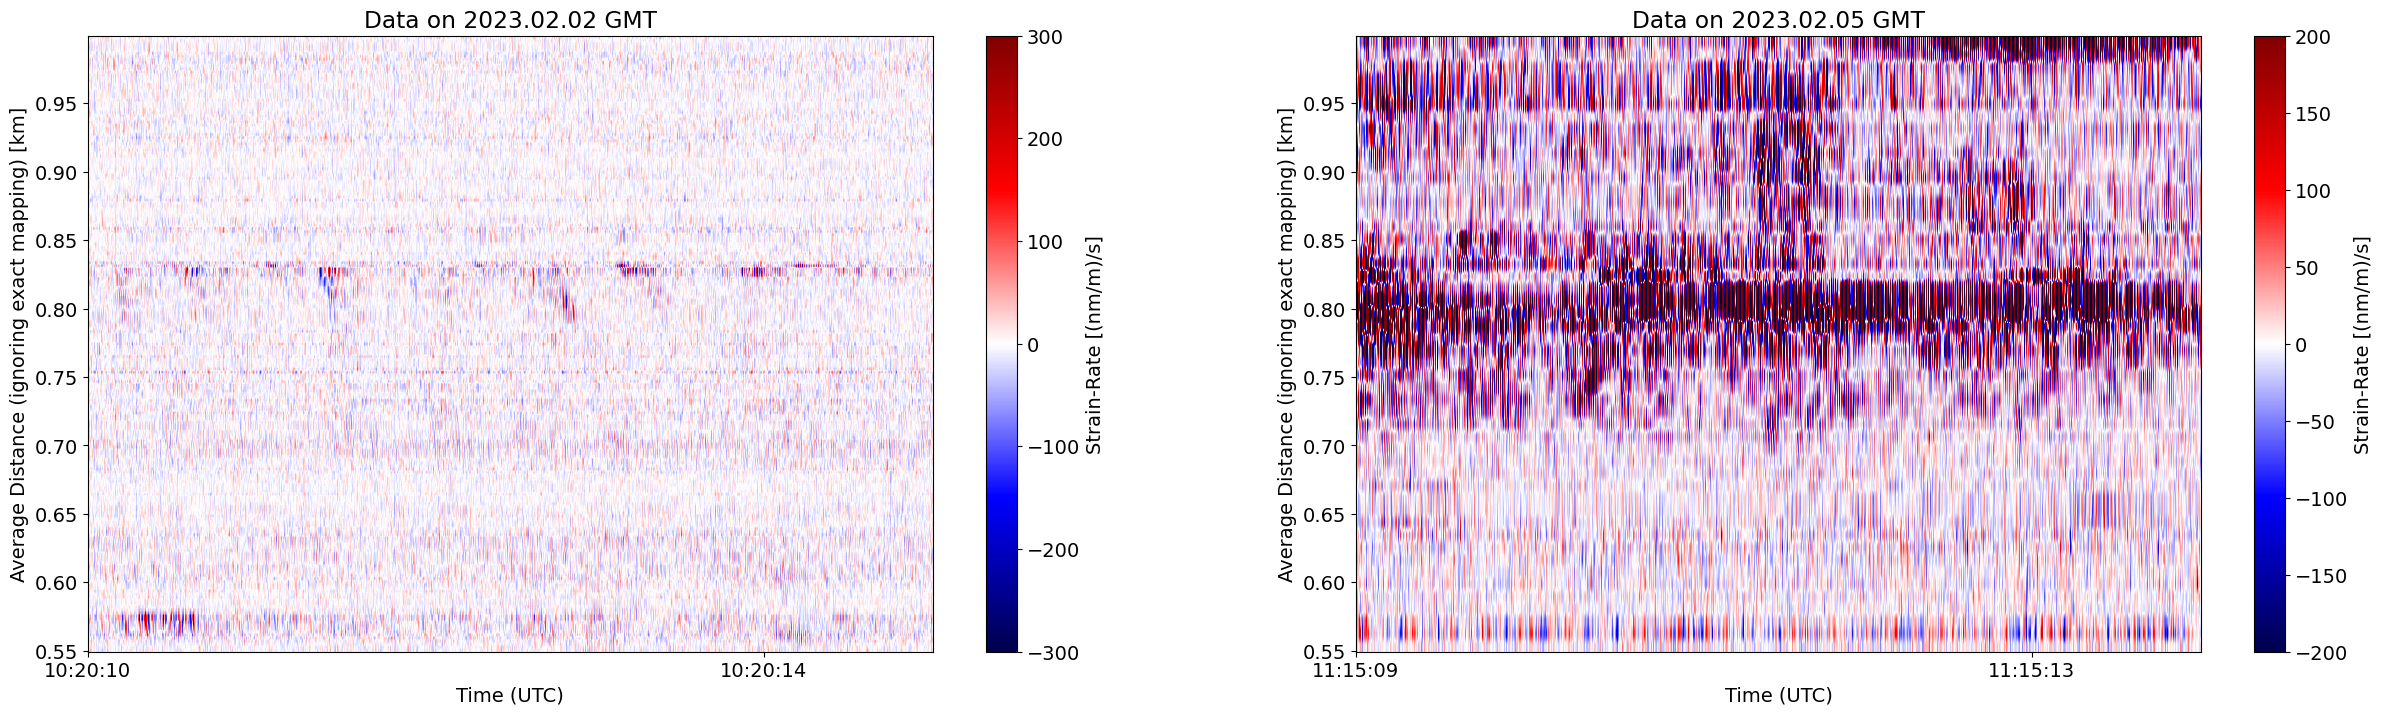

In [10]:
#-- Do a close head-to-head check of the 8m vs 2m channel spacing
t_start = datetime.strptime('2023/02/02 10:20:10.0', '%Y/%m/%d %H:%M:%S.%f') 
t_end   = datetime.strptime('2023/02/02 10:20:15.0', '%Y/%m/%d %H:%M:%S.%f') 
mapping2 = channel_mapping.get_mapping(data_type="clean",chan_spacing=2, d_start=3000, d_end=3100)
data2, headers2, axis2 = load_das_h5.load_das_custom(t_start, t_end, input_dir = input_dir, ichan = mapping2['ii'], verbose=False, convert=True)



t_start = datetime.strptime('2023/02/05 10:22:10.0', '%Y/%m/%d %H:%M:%S.%f') 
t_end   = datetime.strptime('2023/02/05 10:22:15.0', '%Y/%m/%d %H:%M:%S.%f') 
mapping8 = channel_mapping.get_mapping(data_type="clean",chan_spacing=8, d_start=3000, d_end=3100)
data8, headers8, axis8 = load_das_h5.load_das_custom(t_start, t_end, input_dir = input_dir, ichan = mapping8['ii'],  verbose=False, convert=True)

print(np.shape(data2))
print(np.shape(data8))
print(mapping2['ii'][0:10])
print(mapping8['ii'][0:10])

fig,ax = plt.subplot_mosaic("AB",figsize=(30,8))
ax['A'] = waterfall(data2,headers2,mapping2,ax['A'],vlim=300)
ax['B'] = waterfall(data8,headers8,mapping8,ax['B'],vlim=200)

#-----------------------------------------------------------------
#-- Do a close head-to-head check of the 8m vs 2m channel spacing
t_start = datetime.strptime('2023/02/02 10:20:10.0', '%Y/%m/%d %H:%M:%S.%f') 
t_end   = datetime.strptime('2023/02/02 10:20:15.0', '%Y/%m/%d %H:%M:%S.%f') 
mapping2 = channel_mapping.get_mapping(data_type="clean",chan_spacing=2, d_start=0, d_end=1000)
data2, headers2, axis2 = load_das_h5.load_das_custom(t_start, t_end, input_dir = input_dir, ichan = mapping2['ii'], verbose=False, convert=True)



t_start = datetime.strptime('2023/02/05 11:15:10.0', '%Y/%m/%d %H:%M:%S.%f') 
t_end   = datetime.strptime('2023/02/05 11:15:15.0', '%Y/%m/%d %H:%M:%S.%f') 
mapping8 = channel_mapping.get_mapping(data_type="clean",chan_spacing=8, d_start=0, d_end=1000)
data8, headers8, axis8 = load_das_h5.load_das_custom(t_start, t_end, input_dir = input_dir, ichan = mapping8['ii'],  verbose=False, convert=True)

print(np.shape(data2))
print(np.shape(data8))
print(mapping2['ii'][0:10])
print(mapping8['ii'][0:10])

fig,ax = plt.subplot_mosaic("AB",figsize=(30,8))
ax['A'] = waterfall(data2,headers2,mapping2,ax['A'],vlim=300)
ax['B'] = waterfall(data8,headers8,mapping8,ax['B'],vlim=200)
